# Voice recognition testing ground

In [1]:
import requests
from pyaudio import PyAudio
import struct
from forgebox.imports import *
import pyaudio
from functools import partial
from ipywidgets import Button, HBox
from base64 import b64encode
import wave
from io import BytesIO
from getmac import get_mac_address as gma
from datetime import datetime

## Arguements

In [2]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
RATE = 16000
CHANNELS = 1

In [3]:
basics = dict(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    frames_per_buffer = CHUNK
)

In [4]:
pya = pyaudio.PyAudio()
get_input_stream = partial(
    pya.open,
    **basics,
    input=True,
    output=False,
    )

get_output_stream = partial(
    pya.open,
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=False,
    output=True,
    frames_per_buffer = CHUNK)

In [5]:
def chunk_array(data):
    chunk_data = np.array(
        struct.unpack(f"{len(data)}B",data), dtype="b")[::2]+127
    return chunk_data

In [6]:
def get_access_token():
    with open("/etc/baidu_api.json","r") as f:
        api_config = json.load(f)
    API_KEY = api_config["api_key"]
    SECRET_KEY = api_config["secret_key"]
    host = f'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id={API_KEY}&client_secret={SECRET_KEY}'
    response = requests.get(host)
    if response:
        return response.json()["access_token"]

In [7]:
def get_ts():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [8]:
class SoundControl:
    def __init__(self,):
        self.frames = []
        
    def start_record(self):
        print(f"[START REC]{get_ts()}")
        self.record_btn.description = "...Press Stop to interrupt"
        self.in_ = get_input_stream()
        try:
            while True:
                self.frames.append(self.in_.read(CHUNK))
        except KeyboardInterrupt:
            self.stop_record()
        
    def stop_record(self):
        print(f"[STOP REC]{get_ts()}:Total frame length {len(self.frames)}")
        self.record_btn.description = "Record"
        self.in_.close()
        self.data = b''.join(self.frames)
        self.frames=[]
        
    def record(self,_):
        if self.frames.__len__()==0:
            self.start_record()
        else:
            self.stop_record()

    def play(self,_):
        if hasattr(self,"data"):
            self.out=get_output_stream()
            self.out.write(self.data)
            self.out.close()
        else:
            print("No sound recorded")

    def listen(self, language):
        dev_pid = {"en":1737, "zh":1537}[language]
        r_data = dict({
            "format":"wav",
            "rate":RATE,
            "channel":"1",
            "cuid":gma(),
            "token":get_access_token(),
            "dev_pid":dev_pid,
            "len":len(self.data),
            "speech":b64encode(self.data).decode()
            })
        
        r = requests.post("http://vop.baidu.com/server_api ",json = r_data)
        rt = r.json()
        if "result" in rt:
            return rt["result"]
        return rt
    
    def to_text(self,_):
        print(self.listen("zh"))
        
    def to_text_en(self,_):
        print(self.listen("en"))

    def start(self):
        self.record_btn = Button(description="🔴 Record")
        self.record_btn.on_click(self.record)
        
        self.play_btn = Button(description="▶️ Play")
        self.play_btn.on_click(self.play)
        
        self.to_text_btn = Button(description="🇨🇳 Text")
        self.to_text_btn.on_click(self.to_text)
        
        self.to_text_en_btn = Button(description="🇺🇸 Text")
        self.to_text_en_btn.on_click(self.to_text_en)
        
        return HBox([self.record_btn, self.play_btn, self.to_text_btn, self.to_text_en_btn])

In [9]:
sound = SoundControl()

In [10]:
sound.start()

[START REC]2020-12-09 17:50:18
[STOP REC]2020-12-09 17:50:20:Total frame length 35
[START REC]2020-12-09 17:54:53
[STOP REC]2020-12-09 17:54:59:Total frame length 93
[START REC]2020-12-09 17:55:34
[STOP REC]2020-12-09 17:55:41:Total frame length 119


## Visualize spectrogram

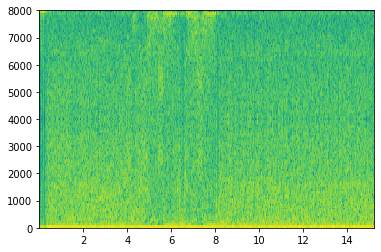

In [19]:
spectrum, freqs, t, im = plt.specgram(
    x=np.array(
        struct.unpack(
            f'{len(sound.data)}B', sound.data
        )
    ),
    Fs=RATE)